<a href="https://colab.research.google.com/github/CentralLT/DeepLearningCoursera/blob/master/Project_image_captioning_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-08-11 04:26:23--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-08-11 04:26:23 (59.2 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
*****************

In [ ]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [ ]:
import sys
sys.path.append("..")
import grading
import download_utils

In [ ]:
download_utils.link_all_keras_resources()

In [ ]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


In [ ]:
#Load tensorboard
%load_ext tensorboard

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Prepare the storage for model checkpoints

In [ ]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/colab/weights_10


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [ ]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [ ]:
# token expires every 30 min
COURSERA_TOKEN = 'xxx'  ### YOUR TOKEN HERE
COURSERA_EMAIL = 'xxx' ### YOUR EMAIL HERE

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [ ]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/inceptionv3.png?raw=1" style="width:70%">

In [ ]:
IMG_SIZE = 299

In [ ]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [ ]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [ ]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [ ]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


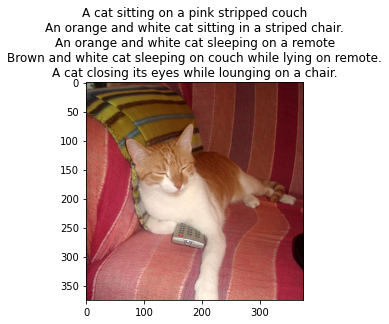

In [ ]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [ ]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [ ]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    from collections import Counter
    words = []
    for i in range(0, len(train_captions)):
      for sentence in train_captions[i]:
        words.extend(split_sentence(sentence))
    wordsCount = Counter(words)
    vocab = []
    
    for key, value in wordsCount.items():
      if value >= 5:
        vocab.extend([key])
    vocab.extend([PAD, UNK, START, END])
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """

    res = []
    for caparray in captions:
      arrayIndex = []
      for sentence in caparray:
        splitSentence = split_sentence(sentence)
        sentenceIndex = [vocab[START]]
        for i in range(0, len(splitSentence)+1):
          try:
            sentenceIndex.extend([vocab[splitSentence[i]]])
          except KeyError:
            sentenceIndex.extend([vocab[UNK]])
          except IndexError:
            sentenceIndex.extend([vocab[END]])
        arrayIndex.append(sentenceIndex)
      res.append(arrayIndex)
     

  
    return res

In [ ]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [ ]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)
print(val_captions_indexed[:5])

[[[2, 54, 6587, 6888, 5155, 7804, 5619, 8647, 7804, 4367, 3795, 691, 3709, 0], [2, 54, 761, 3998, 6888, 5155, 7804, 6081, 5025, 7905, 7804, 4211, 249, 54, 4367, 3795, 0], [2, 8568, 761, 6888, 3885, 3175, 5127, 54, 4371, 8647, 54, 6179, 6367, 0], [2, 54, 6587, 6271, 5155, 54, 1724, 8439, 8647, 7804, 5120, 249, 54, 4371, 3885, 7804, 485, 0], [2, 54, 6587, 6888, 5155, 54, 1326, 4316, 80, 3173, 54, 4371, 5812, 0]], [[2, 54, 8608, 8367, 5127, 54, 3237, 402, 54, 8686, 0], [2, 242, 2630, 5704, 3998, 5155, 7804, 1715, 2227, 4975, 54, 8608, 0], [2, 54, 2227, 5025, 7905, 54, 8608, 8647, 54, 4242, 249, 54, 4884, 0], [2, 54, 7645, 8647, 54, 4242, 6888, 5025, 7905, 242, 5174, 8608, 0], [2, 54, 4242, 249, 54, 5704, 5155, 54, 7645, 0]], [[2, 54, 7743, 656, 6885, 233, 54, 7354, 7639, 249, 54, 5072, 5127, 6173, 0], [2, 54, 1586, 6739, 8647, 54, 7354, 867, 249, 54, 7743, 656, 0], [2, 54, 8367, 5127, 54, 7743, 656, 6888, 3885, 54, 1348, 3885, 54, 5714, 6372, 0], [2, 7804, 7491, 7743, 656, 3998, 8199, 54,

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [ ]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len == None:
      columns = max(map(len, batch_captions))
    else:
      columns = min(max_len, max(map(len, batch_captions)))
    rows = len(batch_captions)
    matrix = np.full((rows,columns), pad_idx)
    for i in range(0, len(batch_captions)):
      if len(batch_captions[i]) >= columns:
        matrix[i][:columns] = batch_captions[i][:columns]
      else:
        matrix[i][:len(batch_captions[i])] = batch_captions[i][:len(batch_captions)]
    return matrix

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [ ]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [ ]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [ ]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/flatten_help.jpg?raw=1" style="width:80%">

In [ ]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, input_shape=(None, LSTM_UNITS),
                              activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab), input_shape=(None, LOGIT_BOTTLENECK), 
                           activation = 'elu')
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    

    
    #c0 = h0 = tf.tile(img_embeds, LSTM_UNITS)
                             ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.

    word_embeds = word_embed(sentences[:,:-1])
    
     
    ### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    ### YOUR CODE HERE ###
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    ### YOUR CODE HERE ###
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
        ### YOUR CODE HERE ###
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1,])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)
    flat_loss_mask = tf.cast(flat_loss_mask, dtype='float32')    ### YOUR CODE HERE ###
   
    flat_loss_maskb = tf.ones_like(flat_ground_truth)
    flat_loss_maskb = flat_ground_truth != pad_idx
    flat_loss_maskb = tf.cast(flat_loss_maskb, dtype = 'float32')
    
    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    

    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))
    ### YOUR CODE HERE ###

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [ ]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [ ]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """

    from random import randrange

    k = 1
    oldImgIndex =[]
    batch_captions_matrix = []
    batchCaptionsSelection = []
    randImgIndex = []
    batch_image_embeddings = np.empty((batch_size, images_embeddings.shape[1]))
    while k <= batch_size:
      randImgIndex = randrange(images_embeddings.shape[0])
      while not(randImgIndex in oldImgIndex):
        sample = images_embeddings[randImgIndex]
        #print(randImgIndex)
        #print(sample.shape)
        batch_image_embeddings[(k-1),:] = sample 
        oldImgIndex.append(randImgIndex)
        batchCaptionsSelection = indexed_captions[randImgIndex]
        randCaptionIndex = randrange(len(batchCaptionsSelection))
        batch_captions_matrix.append(batchCaptionsSelection[randCaptionIndex])
        k +=1
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, vocab[PAD], max_len)
    

    #sample = random.sample(list(range(len(images_embeddings))),batch_size)
    #batch_image_embeddings = images_embeddings[sample]
    #batch_captions = [random.choice(caption) for caption in indexed_captions[sample]]
    #batch_captions_matrix = batch_captions_to_matrix(batch_captions, vocab[PAD], max_len)
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [ ]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [ ]:
# you can load trained weights here
# uncomment the next line if you need to load weights
# saver.restore(s, get_checkpoint_path(epoch=4))

Look at the training and validation loss, they should be decreasing!

In [ ]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.363131
Epoch: 0, train loss: 4.363131385326385, val loss: 3.7593907523155212
**************************************************
Training loss: 3.438113
Epoch: 1, train loss: 3.4381131246089933, val loss: 3.2054073929786684
**************************************************
Training loss: 3.057985
Epoch: 2, train loss: 3.0579846026897433, val loss: 2.988267183303833
**************************************************
Training loss: 2.887779
Epoch: 3, train loss: 2.8877792744636537, val loss: 2.871808431148529
**************************************************
Training loss: 2.792060
Epoch: 4, train loss: 2.792059710741043, val loss: 2.816854341030121
**************************************************
Training loss: 2.722376
Epoch: 5, train loss: 2.7223757519721983, val loss: 2.7502727413177492
Instructions for updating:
Use standard file APIs to delete files with this prefix.
*********************************************

In [ ]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************



In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [ ]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.444447
Accuracy: 0.48817802503477054
Example 0
Predicted: a jet planes flying in formation to in a cloudy sky #END# #END# #END# #END# #END# #END# #END#
Truth: three military aircraft fly in close formation against a grey sky #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man holding a donut of pizza with a store #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a woman eating a piece of pastry in a market area #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man of people on on front two people fighters #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a group of firefighters stand in between two fire trucks #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [ ]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/colab/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [ ]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/colab/weights


In [ ]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [ ]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player holding a bat on a field


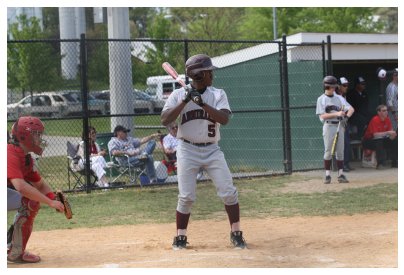

In [ ]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a kitchen with a refrigerator refrigerator and microwave


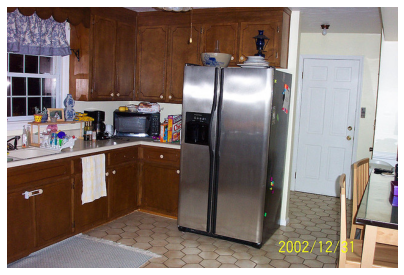

a kitchen with a refrigerator and a microwave


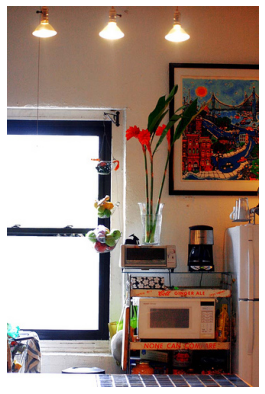

a cat sitting on top of a wooden table


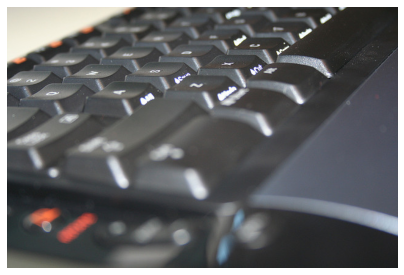

a bowl of fruit with a banana and a bowl of oranges


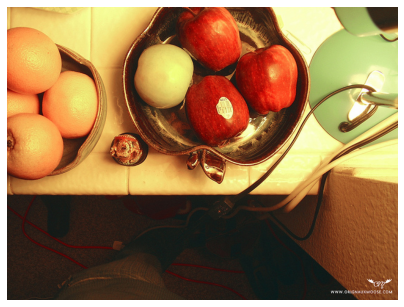

a man cutting a cake with a bunch of bananas


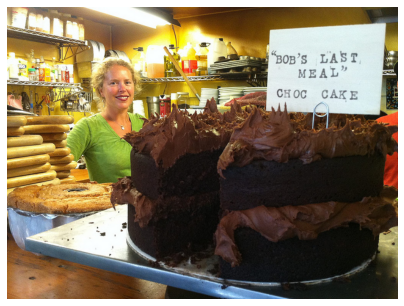

a man riding a horse in a large crowd


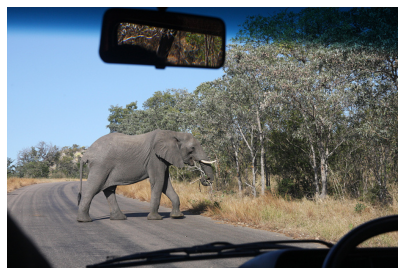

a man in a suit and tie with a tie


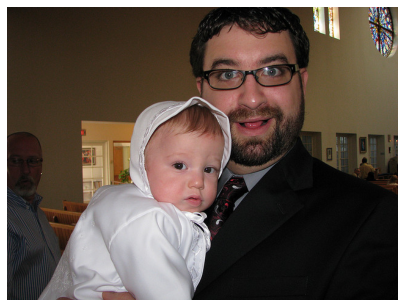

a man riding a snowboard down a snow covered slope


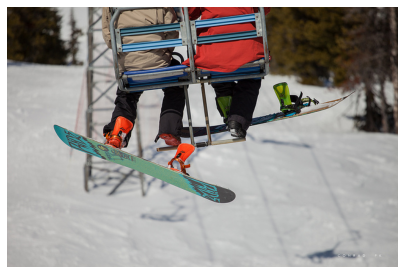

a man standing on a tennis court holding a tennis racket


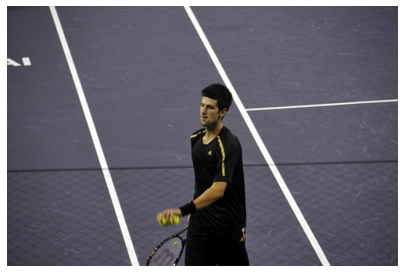

a woman sitting at a table with a pizza


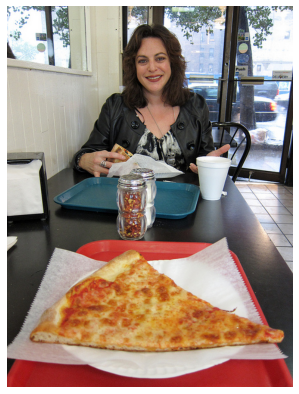

In [ ]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [ ]:
#download_utils.download_file(
#    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
#    "portal-cake-10.jpg"
#)
!wget -O portal-cake-10.jpg http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg

--2020-08-11 05:01:10--  http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg
Resolving www.bijouxandbits.com (www.bijouxandbits.com)... 151.101.2.159
Connecting to www.bijouxandbits.com (www.bijouxandbits.com)|151.101.2.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg [following]
--2020-08-11 05:01:10--  https://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg
Connecting to www.bijouxandbits.com (www.bijouxandbits.com)|151.101.2.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273364 (267K) [image/jpeg]
Saving to: ‘portal-cake-10.jpg’

portal-cake-10.jpg  100%[===================>] 266.96K  --.-KB/s    in 0.04s   

2020-08-11 05:01:10 (7.41 MB/s) - ‘portal-cake-10.jpg’ saved [273364/273364]



a cake with a red and white cake on it


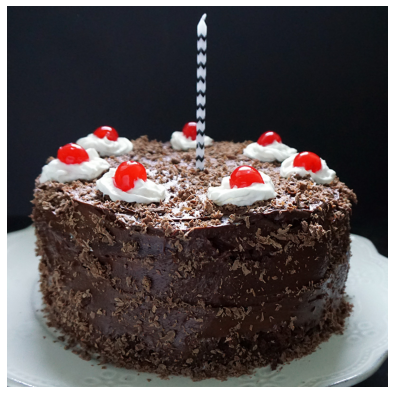

In [ ]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

--2020-08-11 05:33:31--  https://einfachtierisch.de/media/cache/article_content/cms/2013/02/Weisser-Hai-Meer.jpg
Resolving einfachtierisch.de (einfachtierisch.de)... 185.28.76.82
Connecting to einfachtierisch.de (einfachtierisch.de)|185.28.76.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33155 (32K) [image/jpeg]
Saving to: ‘shark.jpg’

shark.jpg           100%[===================>]  32.38K   209KB/s    in 0.2s    

2020-08-11 05:33:32 (209 KB/s) - ‘shark.jpg’ saved [33155/33155]

a man holding a pair of scissors in a room


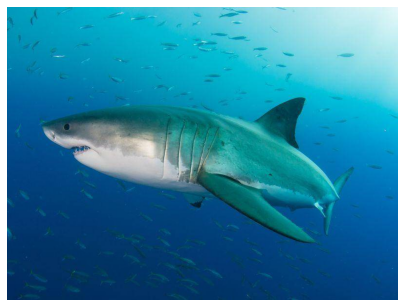

--2020-08-11 05:33:37--  https://einfachtierisch.de/media/cache/article_content/cms/2015/10/Maus-sitzt-auf-Getreide-und-futtert-Korn-shutterstock-Paul-Tymon-301463336.jpg
Resolving einfachtierisch.de (einfachtierisch.de)... 185.28.76.82
Connecting to einfachtierisch.de (einfachtierisch.de)|185.28.76.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41162 (40K) [image/jpeg]
Saving to: ‘mouse.jpg’

mouse.jpg           100%[===================>]  40.20K   258KB/s    in 0.2s    

2020-08-11 05:33:38 (258 KB/s) - ‘mouse.jpg’ saved [41162/41162]

a bird sitting on a tree branch with a plant


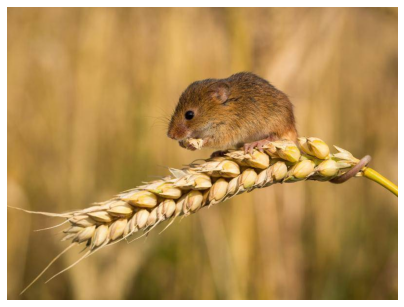

--2020-08-11 05:33:44--  https://www.filmfutter.com/wp-content/uploads/2017/08/EsBilder.jpg
Resolving www.filmfutter.com (www.filmfutter.com)... 37.120.189.126
Connecting to www.filmfutter.com (www.filmfutter.com)|37.120.189.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51793 (51K) [image/jpeg]
Saving to: ‘clown.jpg’

clown.jpg           100%[===================>]  50.58K  --.-KB/s    in 0.1s    

2020-08-11 05:33:45 (341 KB/s) - ‘clown.jpg’ saved [51793/51793]

a woman with a teddy bear in her hand


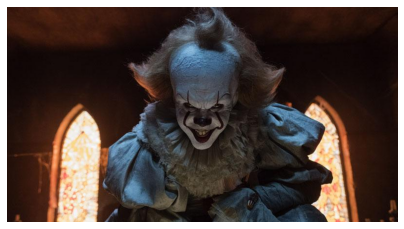

--2020-08-11 05:33:48--  https://cdn.prod.www.spiegel.de/images/d4ec0a39-0001-0004-0000-000001406358_w920_r1.499267935578331_fpx29.99_fpy54.98.jpg
Resolving cdn.prod.www.spiegel.de (cdn.prod.www.spiegel.de)... 8.252.193.250, 8.240.191.250, 8.250.233.250
Connecting to cdn.prod.www.spiegel.de (cdn.prod.www.spiegel.de)|8.252.193.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148540 (145K) [image/jpeg]
Saving to: ‘trash.jpg’

trash.jpg           100%[===================>] 145.06K  --.-KB/s    in 0.02s   

2020-08-11 05:33:49 (7.03 MB/s) - ‘trash.jpg’ saved [148540/148540]

a person is holding a small bird in the air


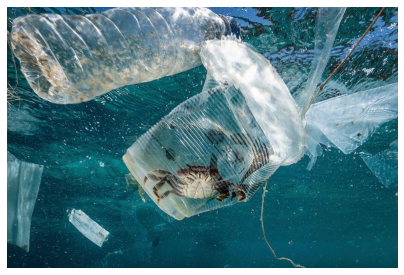

--2020-08-11 05:33:53--  https://www.handelsblatt.com/images/platz-10-city-architecture-and-skyscrapers-near-waterfront/24944298/6-format2020.jpg
Resolving www.handelsblatt.com (www.handelsblatt.com)... 104.19.213.130, 104.19.212.130, 2606:4700::6813:d582, ...
Connecting to www.handelsblatt.com (www.handelsblatt.com)|104.19.213.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115920 (113K) [image/jpeg]
Saving to: ‘city.jpg’

city.jpg            100%[===================>] 113.20K  --.-KB/s    in 0.008s  

2020-08-11 05:33:53 (13.2 MB/s) - ‘city.jpg’ saved [115920/115920]

a group of people walking down a street with umbrellas


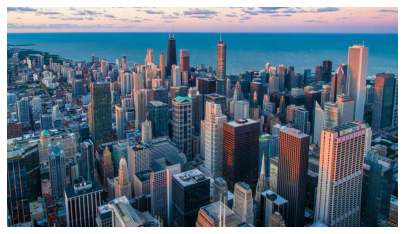

--2020-08-11 05:33:57--  https://i2.wp.com/blog.kodakmoments.de/wp-content/uploads/2020/01/hd-top-fotografie-trends-2020-foto-tipps-besten-bilder-detailfotos-minimalistische-fotos-naturaufnahmen.jpg?fit=1912%2C900
Resolving i2.wp.com (i2.wp.com)... 192.0.77.2
Connecting to i2.wp.com (i2.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1518746 (1.4M) [image/jpeg]
Saving to: ‘mountain.jpg’

mountain.jpg        100%[===================>]   1.45M  9.16MB/s    in 0.2s    

2020-08-11 05:33:57 (9.16 MB/s) - ‘mountain.jpg’ saved [1518746/1518746]

a boat is sailing through the water with a bridge


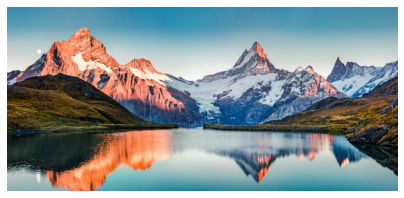

--2020-08-11 05:34:01--  https://lh3.googleusercontent.com/proxy/2LbzRoH5r1OPTkaIsbnkUhSfOB4MsfhAysG9rVuQQTXeQxnDui0jRtgdRwBGg6VcKUHG-h_ZwxHQIxrWwyRApuZSabMrO80TwgxpHcfP
Resolving lh3.googleusercontent.com (lh3.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c07::84
Connecting to lh3.googleusercontent.com (lh3.googleusercontent.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16345 (16K) [image/png]
Saving to: ‘tom.jpg’

tom.jpg             100%[===================>]  15.96K  --.-KB/s    in 0s      

2020-08-11 05:34:01 (108 MB/s) - ‘tom.jpg’ saved [16345/16345]

a man with a tie and a red tie


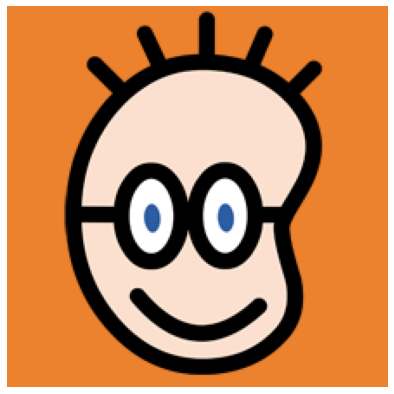

/bin/bash: =1d419aa: command not found
--2020-08-11 05:34:07--  https://mediaproxy.nordbayern.de/v3/image/images.nordbayern.de/ThumbnailatorAspectResizeFilter/w396dp/image/contentid/policy:1.10036820:1587207174/maske%20venezuela.jpg?f=4%3A3
Resolving mediaproxy.nordbayern.de (mediaproxy.nordbayern.de)... 8.240.228.124, 8.240.191.252, 8.252.195.124
Connecting to mediaproxy.nordbayern.de (mediaproxy.nordbayern.de)|8.240.228.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17753 (17K) [image/jpeg]
Saving to: ‘woman.jpg’

woman.jpg           100%[===================>]  17.34K  --.-KB/s    in 0.007s  

2020-08-11 05:34:07 (2.45 MB/s) - ‘woman.jpg’ saved [17753/17753]

a man with a hat and a hat on his head


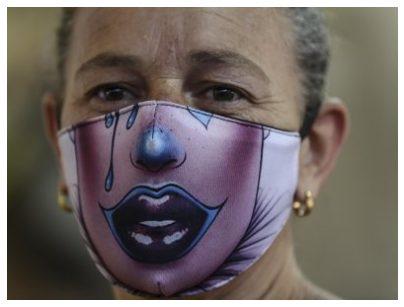

--2020-08-11 05:34:11--  https://onlinetierbedarf.de/wp-content/uploads/2016/11/Schildkr%C3%B6ten-Bilder.jpg
Resolving onlinetierbedarf.de (onlinetierbedarf.de)... 85.13.134.211
Connecting to onlinetierbedarf.de (onlinetierbedarf.de)|85.13.134.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88731 (87K) [image/jpeg]
Saving to: ‘turtel.jpg’

turtel.jpg          100%[===================>]  86.65K   266KB/s    in 0.3s    

2020-08-11 05:34:12 (266 KB/s) - ‘turtel.jpg’ saved [88731/88731]

a large bird is standing on a tree branch


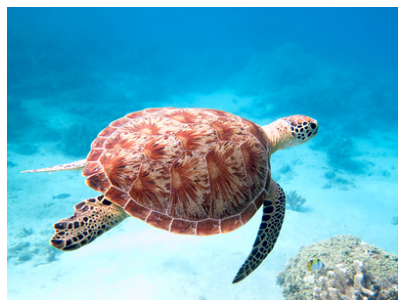

--2020-08-11 05:34:14--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSxh0NEvJ2HrvGXp4IJx_Kb7UMZLbXFKNTC6g
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.20.113, 74.125.20.139, 74.125.20.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6690 (6.5K) [image/jpeg]
Saving to: ‘manbaby.jpg’

manbaby.jpg         100%[===================>]   6.53K  --.-KB/s    in 0s      

2020-08-11 05:34:14 (65.9 MB/s) - ‘manbaby.jpg’ saved [6690/6690]

a woman sitting on a couch with a cake


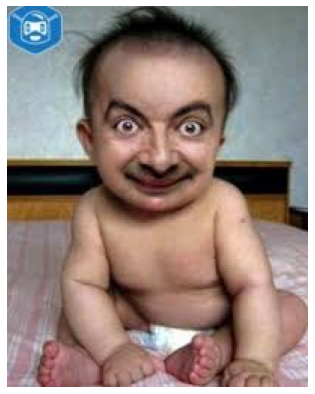

In [ ]:
### YOUR EXAMPLES HERE ###
# Examples that don't work

!wget -O shark.jpg https://einfachtierisch.de/media/cache/article_content/cms/2013/02/Weisser-Hai-Meer.jpg 

apply_model_to_image_raw_bytes(open("shark.jpg", "rb").read())

!wget -O mouse.jpg https://einfachtierisch.de/media/cache/article_content/cms/2015/10/Maus-sitzt-auf-Getreide-und-futtert-Korn-shutterstock-Paul-Tymon-301463336.jpg 

apply_model_to_image_raw_bytes(open("mouse.jpg", "rb").read())

!wget -O clown.jpg https://www.filmfutter.com/wp-content/uploads/2017/08/EsBilder.jpg

apply_model_to_image_raw_bytes(open("clown.jpg", "rb").read())

!wget -O trash.jpg https://cdn.prod.www.spiegel.de/images/d4ec0a39-0001-0004-0000-000001406358_w920_r1.499267935578331_fpx29.99_fpy54.98.jpg

apply_model_to_image_raw_bytes(open("trash.jpg", "rb").read())

!wget -O city.jpg https://www.handelsblatt.com/images/platz-10-city-architecture-and-skyscrapers-near-waterfront/24944298/6-format2020.jpg

apply_model_to_image_raw_bytes(open("city.jpg", "rb").read())

!wget -O mountain.jpg https://i2.wp.com/blog.kodakmoments.de/wp-content/uploads/2020/01/hd-top-fotografie-trends-2020-foto-tipps-besten-bilder-detailfotos-minimalistische-fotos-naturaufnahmen.jpg?fit=1912%2C900

apply_model_to_image_raw_bytes(open("mountain.jpg", "rb").read())

!wget -O tom.jpg https://lh3.googleusercontent.com/proxy/2LbzRoH5r1OPTkaIsbnkUhSfOB4MsfhAysG9rVuQQTXeQxnDui0jRtgdRwBGg6VcKUHG-h_ZwxHQIxrWwyRApuZSabMrO80TwgxpHcfP

apply_model_to_image_raw_bytes(open("tom.jpg", "rb").read())

!wget -O woman.jpg https://mediaproxy.nordbayern.de/v3/image/images.nordbayern.de/ThumbnailatorAspectResizeFilter/w396dp/image/contentid/policy:1.10036820:1587207174/maske%20venezuela.jpg?f=4%3A3&h=960&m=FIT&w=1800&$p$f$h$m$w=1d419aa

apply_model_to_image_raw_bytes(open("woman.jpg", "rb").read())

!wget -O turtel.jpg https://onlinetierbedarf.de/wp-content/uploads/2016/11/Schildkr%C3%B6ten-Bilder.jpg

apply_model_to_image_raw_bytes(open("turtel.jpg", "rb").read())

!wget -O manbaby.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSxh0NEvJ2HrvGXp4IJx_Kb7UMZLbXFKNTC6g&usqp=CAU

apply_model_to_image_raw_bytes(open("manbaby.jpg", "rb").read())

--2020-08-11 05:34:18--  https://images.motorsport-magazin.com/images/600/400/q_80/0903497.jpg
Resolving images.motorsport-magazin.com (images.motorsport-magazin.com)... 149.154.99.239
Connecting to images.motorsport-magazin.com (images.motorsport-magazin.com)|149.154.99.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54576 (53K) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]  53.30K   161KB/s    in 0.3s    

2020-08-11 05:34:19 (161 KB/s) - ‘car.jpg’ saved [54576/54576]

a red and white car is parked on a curb


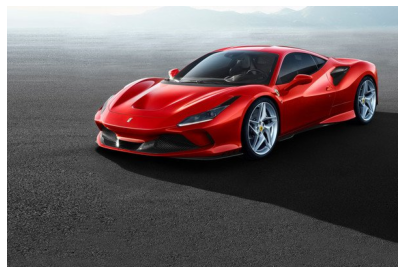

--2020-08-11 05:34:23--  https://image.jimcdn.com/app/cms/image/transf/dimension=1920x400:format=jpg/path/sff0b929dc64ab22e/image/ib4511a3cfc553a88/version/1557436730/image.jpg
Resolving image.jimcdn.com (image.jimcdn.com)... 151.101.2.2, 151.101.66.2, 151.101.130.2, ...
Connecting to image.jimcdn.com (image.jimcdn.com)|151.101.2.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32498 (32K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  31.74K  --.-KB/s    in 0.008s  

2020-08-11 05:34:23 (3.68 MB/s) - ‘dog.jpg’ saved [32498/32498]

a dog is standing in the grass with a bottle


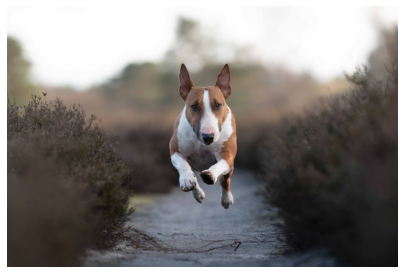

--2020-08-11 05:34:27--  https://www.paintit.de/images/blog/397-diese-10-bilder-sind-die-beruhmtesten-gemalde-der-welt-27df493a9487aff470ddb4cb56c94567.jpg
Resolving www.paintit.de (www.paintit.de)... 185.187.75.180
Connecting to www.paintit.de (www.paintit.de)|185.187.75.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41587 (41K) [image/jpeg]
Saving to: ‘monalisa.jpg’

monalisa.jpg        100%[===================>]  40.61K   265KB/s    in 0.2s    

2020-08-11 05:34:28 (265 KB/s) - ‘monalisa.jpg’ saved [41587/41587]

a woman in a dress holding a white and white tie


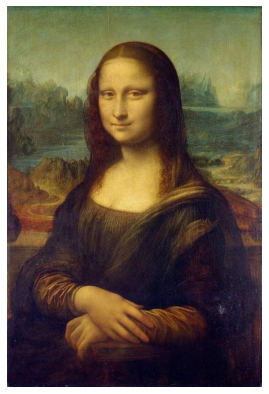

--2020-08-11 05:34:32--  https://einfachtierisch.de/media/cache/article_teaser/cms/2015/08/Deutscher-Schaeferhund-Welpe-auf-Wiese-shutterstock-Rita-Kochmarjova-288907253.jpg?595617
Resolving einfachtierisch.de (einfachtierisch.de)... 185.28.76.82
Connecting to einfachtierisch.de (einfachtierisch.de)|185.28.76.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165215 (161K) [image/jpeg]
Saving to: ‘puppy.jpg’

puppy.jpg           100%[===================>] 161.34K   211KB/s    in 0.8s    

2020-08-11 05:34:34 (211 KB/s) - ‘puppy.jpg’ saved [165215/165215]

a small dog is sitting on a bench


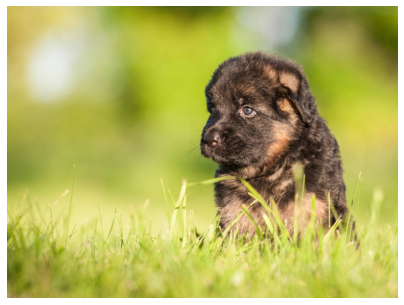

--2020-08-11 05:34:38--  https://m.ostsee-zeitung.de/var/storage/images/oz/mehr/bilder/fotostrecken-bilder/2020/8/bilder-von-der-einschulungsfeier/32306280-d805-11ea-9bf3-fe0e1ee6cd00/750762040-1-ger-DE/32306280-d805-11ea-9bf3-fe0e1ee6cd00_mobile_gallery_detail@2x.jpg
Resolving m.ostsee-zeitung.de (m.ostsee-zeitung.de)... 23.6.104.92
Connecting to m.ostsee-zeitung.de (m.ostsee-zeitung.de)|23.6.104.92|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.ostsee-zeitung.de/var/storage/images/oz/mehr/bilder/fotostrecken-bilder/2020/8/bilder-von-der-einschulungsfeier/32306280-d805-11ea-9bf3-fe0e1ee6cd00/750762040-1-ger-DE/32306280-d805-11ea-9bf3-fe0e1ee6cd00_mobile_gallery_detail@2x.jpg [following]
--2020-08-11 05:34:38--  https://www.ostsee-zeitung.de/var/storage/images/oz/mehr/bilder/fotostrecken-bilder/2020/8/bilder-von-der-einschulungsfeier/32306280-d805-11ea-9bf3-fe0e1ee6cd00/750762040-1-ger-DE/32306280-d805-11ea-9bf3-fe0e1ee6cd00_mobil

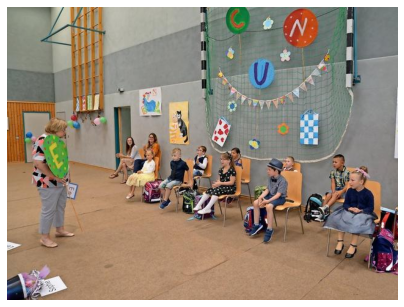

--2020-08-11 05:34:42--  https://www.sueddeutsche.de/image/sz.1.4895519/974x731?v=1588503010
Resolving www.sueddeutsche.de (www.sueddeutsche.de)... 13.224.29.26, 13.224.29.60, 13.224.29.84, ...
Connecting to www.sueddeutsche.de (www.sueddeutsche.de)|13.224.29.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297573 (291K) [image/jpeg]
Saving to: ‘bench.jpg’

bench.jpg           100%[===================>] 290.60K  --.-KB/s    in 0.03s   

2020-08-11 05:34:42 (10.4 MB/s) - ‘bench.jpg’ saved [297573/297573]

a man sitting on a bench with a dog


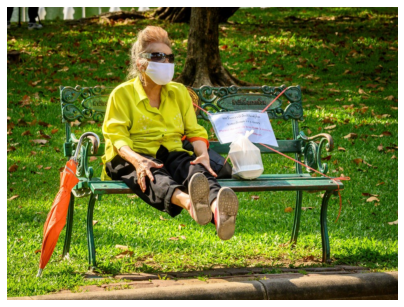

--2020-08-11 05:34:45--  https://malen-lernen.org/wp-content/uploads/2019/03/beruehmte-gemaelde-bilder.jpg
Resolving malen-lernen.org (malen-lernen.org)... 80.74.152.100
Connecting to malen-lernen.org (malen-lernen.org)|80.74.152.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119048 (116K) [image/jpeg]
Saving to: ‘art.jpg’

art.jpg             100%[===================>] 116.26K   405KB/s    in 0.3s    

2020-08-11 05:34:47 (405 KB/s) - ‘art.jpg’ saved [119048/119048]

a man sitting on a bench with a clock


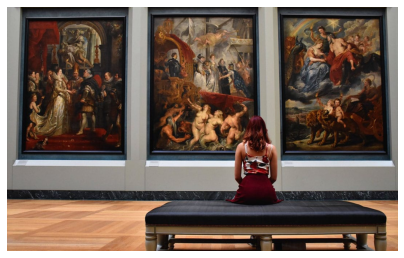

--2020-08-11 05:34:50--  https://m.sn-online.de/var/storage/images/sn/mehr/bilder/summer-of-lovers/sn-kochbeck10-0308/750459189-1-ger-DE/sn-kochbeck10-0308_mobile_default_3_2@2x.jpg
Resolving m.sn-online.de (m.sn-online.de)... 23.6.104.92
Connecting to m.sn-online.de (m.sn-online.de)|23.6.104.92|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.sn-online.de/var/storage/images/sn/mehr/bilder/summer-of-lovers/sn-kochbeck10-0308/750459189-1-ger-DE/sn-kochbeck10-0308_mobile_default_3_2@2x.jpg [following]
--2020-08-11 05:34:50--  https://www.sn-online.de/var/storage/images/sn/mehr/bilder/summer-of-lovers/sn-kochbeck10-0308/750459189-1-ger-DE/sn-kochbeck10-0308_mobile_default_3_2@2x.jpg
Resolving www.sn-online.de (www.sn-online.de)... 23.6.104.92
Connecting to www.sn-online.de (www.sn-online.de)|23.6.104.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43355 (42K) [image/jpeg]
Saving to: ‘singer.jpg’

singer.jpg

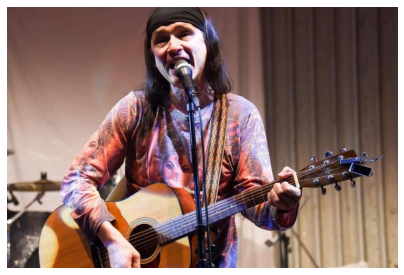

--2020-08-11 05:34:54--  https://static.giga.de/wp-content/uploads/2017/03/whatsapp-status-bild-speichern-affengriff1.jpg
Resolving static.giga.de (static.giga.de)... 178.19.70.100
Connecting to static.giga.de (static.giga.de)|178.19.70.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117061 (114K) [image/jpeg]
Saving to: ‘mobile.jpg’

mobile.jpg          100%[===================>] 114.32K   287KB/s    in 0.4s    

2020-08-11 05:34:56 (287 KB/s) - ‘mobile.jpg’ saved [117061/117061]

a person holding a remote control in his hand


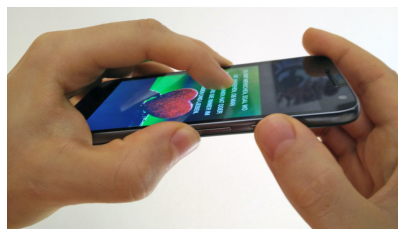

--2020-08-11 05:34:59--  https://www.daserste.de/unterhaltung/soaps-telenovelas/sturm-der-liebe/specials/-15-jahre-jubilaeum-bilder-sondermotive-114~_v-varm_b9e64d.jpg
Resolving www.daserste.de (www.daserste.de)... 8.248.49.252
Connecting to www.daserste.de (www.daserste.de)|8.248.49.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29411 (29K) [image/jpeg]
Saving to: ‘soap.jpg’

soap.jpg            100%[===================>]  28.72K  --.-KB/s    in 0.05s   

2020-08-11 05:34:59 (607 KB/s) - ‘soap.jpg’ saved [29411/29411]

a man and woman standing in front of a building


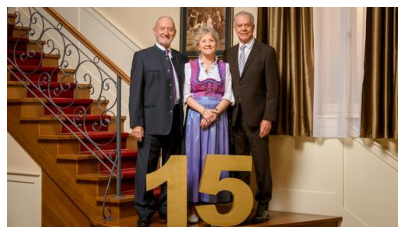

In [ ]:
!wget -O car.jpg https://images.motorsport-magazin.com/images/600/400/q_80/0903497.jpg

apply_model_to_image_raw_bytes(open("car.jpg", "rb").read())

!wget -O dog.jpg https://image.jimcdn.com/app/cms/image/transf/dimension=1920x400:format=jpg/path/sff0b929dc64ab22e/image/ib4511a3cfc553a88/version/1557436730/image.jpg

apply_model_to_image_raw_bytes(open("dog.jpg", "rb").read())

!wget -O monalisa.jpg https://www.paintit.de/images/blog/397-diese-10-bilder-sind-die-beruhmtesten-gemalde-der-welt-27df493a9487aff470ddb4cb56c94567.jpg

apply_model_to_image_raw_bytes(open("monalisa.jpg", "rb").read())

!wget -O puppy.jpg https://einfachtierisch.de/media/cache/article_teaser/cms/2015/08/Deutscher-Schaeferhund-Welpe-auf-Wiese-shutterstock-Rita-Kochmarjova-288907253.jpg?595617

apply_model_to_image_raw_bytes(open("puppy.jpg", "rb").read())

!wget -O pupils.jpg https://m.ostsee-zeitung.de/var/storage/images/oz/mehr/bilder/fotostrecken-bilder/2020/8/bilder-von-der-einschulungsfeier/32306280-d805-11ea-9bf3-fe0e1ee6cd00/750762040-1-ger-DE/32306280-d805-11ea-9bf3-fe0e1ee6cd00_mobile_gallery_detail@2x.jpg

apply_model_to_image_raw_bytes(open("pupils.jpg", "rb").read())

!wget -O bench.jpg https://www.sueddeutsche.de/image/sz.1.4895519/974x731?v=1588503010&cropRatios=0:0-BiGa-www&cropRatios=3:2&cropRatios=2:3&method=resize

apply_model_to_image_raw_bytes(open("bench.jpg", "rb").read())

!wget -O art.jpg https://malen-lernen.org/wp-content/uploads/2019/03/beruehmte-gemaelde-bilder.jpg

apply_model_to_image_raw_bytes(open("art.jpg", "rb").read())

!wget -O singer.jpg https://m.sn-online.de/var/storage/images/sn/mehr/bilder/summer-of-lovers/sn-kochbeck10-0308/750459189-1-ger-DE/sn-kochbeck10-0308_mobile_default_3_2@2x.jpg

apply_model_to_image_raw_bytes(open("singer.jpg", "rb").read())

!wget -O mobile.jpg https://static.giga.de/wp-content/uploads/2017/03/whatsapp-status-bild-speichern-affengriff1.jpg

apply_model_to_image_raw_bytes(open("mobile.jpg", "rb").read())

!wget -O soap.jpg https://www.daserste.de/unterhaltung/soaps-telenovelas/sturm-der-liebe/specials/-15-jahre-jubilaeum-bilder-sondermotive-114~_v-varm_b9e64d.jpg
apply_model_to_image_raw_bytes(open("soap.jpg", "rb").read())

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!